<style type="text/css">
	.myimg {
		max-width: 500px !important;
	}
</style>


# Monkey Type Machine Learn

**A Project by Richard McHorgh**


## Introduction


In the middle of October, I was inspired by YouTube creators, namely [Ben Vallack](https://www.youtube.com/benvallack), to begin designing the printed circuit boards, keycaps, and case for a keyboard. After about a month of assembly, it would become the ortholinear, split, and thumb-maximizing keyboard that I’m using to type this report. I thought it would be the perfect present for my birthday, but the main reason for starting this project was to protect my hands and wrists from the threat of carpal tunnel syndrome and other diseases like it. 

Unlike the traditional row-staggered layout that one would find on the majority of laptop and store-bought keyboards, ortholinear keyboards arrange the keys in a strict grid matrix. This allows for a more ergonomic and efficient typing experience than row-staggered keyboards. Each key is positioned directly under the finger that would normally press it, rather than back and shifted to the left or right by an arbitrary amount. Ortholinear keyboards thereby reduce strain on the fingers and wrists. 

<img class='myimg' alt='A picture of the completed keyboard' src='./img/kb_hat.jpg'/>

*A picture of the completed keyboard*

Furthermore, strain on the fingers, wrists, and back is minimized by the keyboard being split into halves between the positions of the 5 and 6 keys. Traditional keyboards require their users’ hands to be unnaturally close together, forcing their wrists to be at an angle. Contrarily, with a split keyboard, one’s hands can be straight and as far apart as the cable joining the two halves allows.  Arms being in their natural position translates to hands being straight and in as comfortable of a position as possible, especially during long typing sessions. 

<img class='myimg' src='./img/strain.jpg'/>

_Hand angles while using a row staggered keyboard and a split keyboard_

The third ergonomic feature of the design is the programmable thumb clusters that are found on the last row of each half of the keyboard. Row staggered keyboards only use the operator’s thumbs for the spacebar, so to perform shortcuts with the Control, Command, Alt, or any other non-alphanumeric keys, hands must be moved off the keyboard. Each time the user’s fingers move off the home row more strain is introduced to their hands. This strain is compounded when the entire hand must be moved to type a key. With a programmable thumb cluster, all movement (Up, Left, Home, etc.), page management (Alt-Tab), and text manipulation (Undo, Cut, Paste, etc.) shortcuts can be performed without lifting the hands from either half of the keyboard. 

All the ergonomic design features of the keyboard would be less effective without a layout that can magnify them.  Instead of the traditional QWERTY keyboard layout, my keyboard was programmed to use a slightly modified version of the Colemak-DHM layout that I named SemiColemak. Standard Colemak-DHM places letters on the keyboard by their frequency in English words and the relative strength of the finger that is meant to press them. The more common the letter, the stronger the finger assigned to it. Contrarily, QWERTY is organized to minimize the jams of a typewriter, which is nonsensical in an era of electrically controlled keyboards. 

However, due to QWERTY’s ubiquity, it was the keyboard layout that I learned to type while in elementary school. Text manipulation shortcuts are based on the QWERTY layout as well. SemiColemak’s proximity to QWERTY, with 11 keys in the same positions, including z, x, c, and v, makes it easier to learn compared to other ergonomic layouts, such as Dvorak or Workman. 

Although SemiColemak is among the easiest layouts for a transition from QWERTY, the relearning process has been as strenuous for my muscle memory as QWERTY was for my hands and wrists. Even now, in my third week of solely using the keyboard, my typing speed in SemiColemak is barely approaching half of my average on QWERTY. 

The object of this tutorial is to identify the points of error in typing the words that I use most frequently and funnel that data into a classifier that will highlight my weakest features in words that I type. Practicing words with these features will help to increase my speed and accuracy typing on my keyboard. 

## Collecting the raw data


As well as being the inspiration for this project's name, the competitive type racing website, Monkey See Monkey Type is the source of the data used in this project. Generally, the website is abbreviated to Monkey Type. By inserting the JavaScript keylogger written below into the Developer Mode Console in a browser, I was able to record the letter I pressed, the letter I should have pressed, and the source of the text, among other datapoints. 

In [1]:
%pycat data/scrape.js

var monkeyQueue = [];
var monkeyList = [];
var monkeyListen = () => {
        let layout, language, funbox, type, length, activeWord;
        let testNum = 0;

        let setup = () => {
                let words = document.querySelector('#words');
                monkeyQueue = Array.from(words.children).map((v, i, a) => {
                        return i < a.length - 1 ? `${v.innerText} ` : v.innerText;
                }, '');

                let options = Array.from(
                        document
                                .querySelector('#testModesNotice')
                                .querySelectorAll('[commands]')
                );

                layout = options.filter((e) => e.getAttribute('commands') == 'tags')[0]
                        .innerText;
                language = options.filter(
                        (e) => e.getAttribute('commands') == 'languages'
                )[0].innerText;
                let funboxElements = options.filter(
               

The data scraped from the above function is then sent to the Deno localhost webserver transcribed below. Once the POST request is received, the webserver appends it to a comma separated table. If you would like to use this code to analyze your own typing, make sure to start the Deno server before sending any data from the keylogger script. 

In [2]:
%pycat data/save.ts

// import the webserver in the deno way
import { serve } from 'https://deno.land/std@0.157.0/http/server.ts';

type Input = {
        timestamp: Date;
        activeWord: string;
        lastChar: string;
        correctChar: string;
        layout: string;
        type: string;
        length: string;
        language: string;
        testNum: number;
        funbox: string;
};

const handler = async (req: Request) => {
        return await req
                .json()
                .then(async (test: Input[]) => {
                        for (let {
                                timestamp,
                                activeWord,
                                lastChar,
                                correctChar,
                                layout,
                                type,
                                length,
                                language,
                                funbox,
                                testNum
                        } of

## Understanding the data


### Required Imports 


In [3]:
from pandas import read_csv
from matplotlib.pyplot import subplots, legend, tight_layout

In [4]:
df = read_csv("data/data.csv", keep_default_na=False)

### N-Grams


Although it rarely outputs actual words, the Pseudolang funbox option generates words by algorithmically combining the common n-grams of the selected language. An n-gram is a sequence of two adjacent elements from a collection of tokens. In this context, they are the likeliest letter sets. In English, some of the most common 2-grams, or bigrams, include: 

-   th
-   he
-   in
-   er
-   an
-   re
-   nd
-   at
-   on
-   nt


Ingraining frequent n-grams into muscle memory is crucial to improving typing accuracy and speed. SemiColemak positions a few of these bigrams near each other, specifically “in”, “he”, “at”, and “on”, but underneath different fingers of the same hand. By avoiding the use of the same finger to type the n-gram, one can prime the finger assigned to the next letter in the sequence before the key is actually pressed, and as a product, decrease the time needed to type the whole word.  

<img class='myimg' src='./img/kb_legend.jpg'/>

_An image of the legend of the keyboard_

In [5]:
# Calculate the percentage of words with a listed n-gram in the entire dataset

ngrams = ["er", "re", "th", "in","an", "at", "he", "on", "nd",  "nt"]
for x in ngrams:
    print(
        f"Percentage of rows with {x} bigram:\t{round(len(df[df.activeWord.str.contains(x)]) * 100 / len(df))}%"
    )


Percentage of rows with er bigram:	13%
Percentage of rows with re bigram:	10%
Percentage of rows with th bigram:	6%
Percentage of rows with in bigram:	10%
Percentage of rows with an bigram:	6%
Percentage of rows with at bigram:	7%
Percentage of rows with he bigram:	4%
Percentage of rows with on bigram:	9%
Percentage of rows with nd bigram:	3%
Percentage of rows with nt bigram:	6%


### Languages


Monkey Type can generate typing tests in many different languages, so, in order to emulate the words that I use from day to day, about $\frac{2}{3}$ of the tests that I took were comprised of English words, but since I write a lot of Python, JavaScript, C++, Swift and Kotlin, to a lesser degree, French, those languages were added to the test mix.

Since all of the programming languages included use English-based syntax, they share many of the n-grams with English.  Regular English, however, does not train your fingers for coding paradigms, like camel or snake case or using parentheses, equal signs, or comparators frequently. 

<AxesSubplot: >

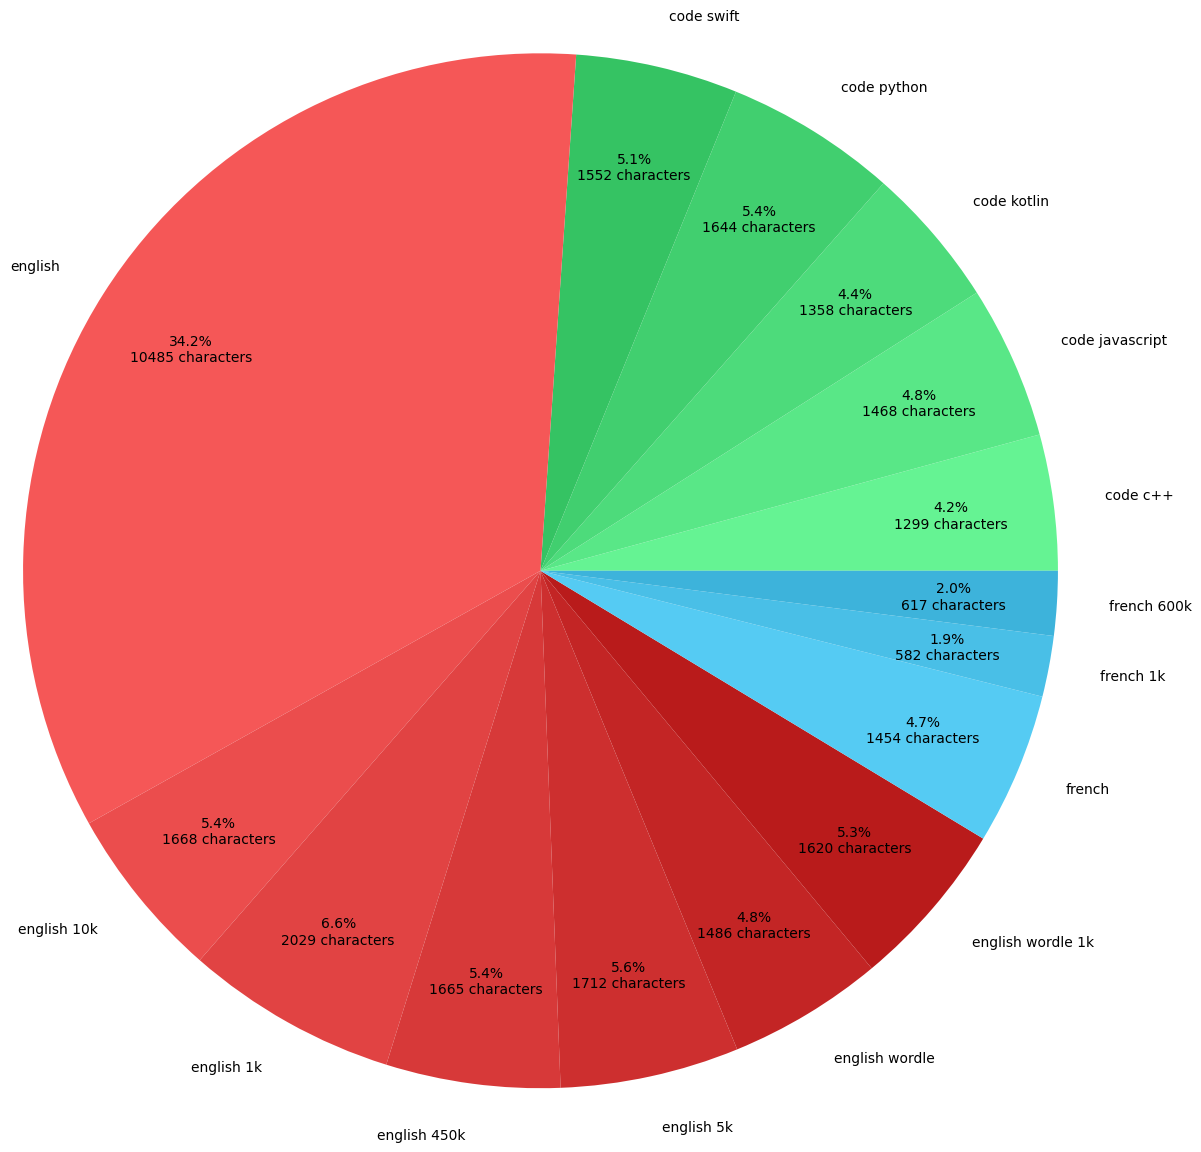

In [6]:
# Get value counts
v = df.language.value_counts().sort_index()

# Generate color gradients
colors = [0] * 3

def pickColor(x):
    if "code" in x or 'git' in x:
        colors[0] += 1
        return "#" + "".join(
            [hex(c - (12 * colors[0]))[2:] for c in [0x71, 0xff, 0x9f]]
        )
    if "english" in x or "wordle" in x:
        colors[1] += 1
        return "#" + "".join(
            [hex(c - (10 * colors[1]))[2:] for c in [0xff, 0x61, 0x61]]
        )
    if "french" in x:
        colors[2] += 1
        return "#" + "".join(
            [hex(c - (12 * colors[2]))[2:] for c in [0x61, 0xD7, 0xff]]
        )

langColors = {x: pickColor(x) for x in v.index}

# Plot pie graph
v.plot.pie(
    radius=3.5,
    ylabel="",
	pctdistance=0.8,
    colors=[langColors[x] for x in v.index],
    labels=v.index,
    autopct=lambda x: f"{round(x, 1)}%\n{int(x * v.sum() / 100)} characters",
)


_English language sets are depicted in various degrees of red, code sets in green, and French in blue._

### Punctuation 


When spoken languages are transcribed, punctuation marks are added. Monkey Type does not add these marks by default, so the __Quote__ test __type__ was used to introduce them. 

In [7]:
# Words with punctuation
df[df["activeWord"].str.contains("'")].head()

,timestamp,activeWord,lastChar,correctChar,layout,testNum,type,length,language,funbox
12295,2022-12-12T13:35:48.619Z,don't,d,d,semicolemakdh,1,quote,25,english,null
12296,2022-12-12T13:35:48.748Z,don't,o,o,semicolemakdh,1,quote,25,english,null
12297,2022-12-12T13:35:48.982Z,don't,n,n,semicolemakdh,1,quote,25,english,null
12298,2022-12-12T13:35:49.428Z,don't,',',semicolemakdh,1,quote,25,english,null
12299,2022-12-12T13:35:49.746Z,don't,t,t,semicolemakdh,1,quote,25,english,null


## Feature Engineering


The first step in identifying the points of error in my keyboard usage is to define a set of error metrics. Once defined and computed, these metrics will be added as columns in the Pandas DataFrame. 

### Required Imports 


In [8]:
from datetime import datetime as dt, timedelta
from pandas import set_option
from numpy import NaN, nan

### Speed and Test Number

Typing speed is calculated in characters per second (cps) rather than the customary unit of measurement, words per minute (wpm). Since there is a high variance in the length of words, using wpm would require some sort of averaging, which would invite information loss. Measuring characters per second does not necessitate averaging because it relies on the smallest non-temporal piece of data, the character. 

Characters per second is calculated by subtracting timestamps between two adjacent characters. This strategy works well when every letter typed is correct. However, since I am still learning, correctly typed characters inevitably precede mistypes. Instead of returning an accurate measurement of the useful characters typed per unit of time, the interval between characters simply returns raw typing speed. To remedy this, the speed of incorrectly typed characters is replaced with the mean of over the active word. 

In [9]:
# Converting timestamps to python's date object

df.timestamp = df.timestamp.apply(lambda x: dt.fromisoformat(x[:-1]))
df.head()

,timestamp,activeWord,lastChar,correctChar,layout,testNum,type,length,language,funbox
0,2022-12-12 07:45:16.438,ninth,n,n,semicolemakdh,1,words,10,english wordle,null
1,2022-12-12 07:45:16.527,ninth,i,i,semicolemakdh,1,words,10,english wordle,null
2,2022-12-12 07:45:16.650,ninth,n,n,semicolemakdh,1,words,10,english wordle,null
3,2022-12-12 07:45:16.881,ninth,t,t,semicolemakdh,1,words,10,english wordle,null
4,2022-12-12 07:45:17.005,ninth,h,h,semicolemakdh,1,words,10,english wordle,null


In [10]:
# Subtract the intervals

df["cps"] = df.timestamp
df.cps = df.cps.sub(df.timestamp.shift()).apply(lambda x: x.total_seconds())

# Show results
df[["timestamp", "lastChar", "cps"]].head()

,timestamp,lastChar,cps
0,2022-12-12 07:45:16.438,n,NaN
1,2022-12-12 07:45:16.527,i,0.089
2,2022-12-12 07:45:16.650,n,0.123
3,2022-12-12 07:45:16.881,t,0.231
4,2022-12-12 07:45:17.005,h,0.124


The intervals between letters in the same word and in the same test are correct, but since tests were not taken consecutively, some intervals are much too large.

In [11]:
df.iloc[[10407, 10408]]

,timestamp,activeWord,lastChar,correctChar,layout,testNum,type,length,language,funbox,cps
10407,2022-12-12 09:31:38.781,faut,t,t,semicolemakdh,79,words,10,french,null,0.556
10408,2022-12-12 13:14:29.763,mark,m,m,semicolemakdh,1,words,10,english 5k,null,13370.982


Although these letters were recorded successively, moving my fingers from the _t_ to _m_ key to begin the word _mark_ did not take nearly 4 hours. To ensure accuracy of the data, the beginning of the interval must align with the start of each test. 

Tests taken in the same browser session are labeled in chronological order, but if the tab running the logger was closed or refreshed, the order was reset to test number 1. Fixing the values in the __testNum__ column is necessary to get the correct cps. 

In [12]:
# Loop over each row
for i, _ in df.iterrows():
	if i + 1 == len(df):
		break

	tn = int(df.at[i, 'testNum'])
	ntn = int(df.at[i + 1, 'testNum'])

	# if i == 5721:
	# 	print('stop')
	
	# If the next row's num is less than the current row's (the rows are misordered)
	if tn > ntn:

		# Change all of the words in the next row's test to the correct number
		j = i + 1
		nln = df.at[j, 'length']
		lastWord = df.at[j, 'activeWord']
		while nln > 0 and j < len(df):
			df.at[j, 'testNum'] = tn + 1

			# If lastWord is different from this word
			if lastWord != df.at[j, 'activeWord']:
				lastWord = df.at[j, 'activeWord']
				nln -= 1

			# If row is the last of its word
			if lastWord[-1] != ' ' and j + 1 < len(df) and df.at[j + 1, 'activeWord'] != lastWord:
				break
			j += 1

Now that the tests are correctly indexed, we set the initial letter in each test to a null value.

In [13]:
# get the first characters in each list
firstChars = df.groupby('testNum').cps.head(1)

# set each start's cps to null value
for i in firstChars.index:
	df.loc[i, 'cps'] = NaN

df[df.testNum == 300].head()

,timestamp,activeWord,lastChar,correctChar,layout,testNum,type,length,language,funbox,cps
24452,2022-12-15 04:27:10.099,since,s,s,semicolemakdh,300,words,25,english,null,NaN
24453,2022-12-15 04:27:10.149,since,i,i,semicolemakdh,300,words,25,english,null,0.050
24454,2022-12-15 04:27:10.321,since,n,n,semicolemakdh,300,words,25,english,null,0.172
24455,2022-12-15 04:27:10.656,since,c,c,semicolemakdh,300,words,25,english,null,0.335
24456,2022-12-15 04:27:10.808,since,e,e,semicolemakdh,300,words,25,english,null,0.152


### Consistency

Consistency is the measure of the difference in cps across the letters of a word. Analyzing the consistency between keypresses will determine the bigrams and trigrams that require the most practice. 

$$\text{consistency score} = \text{cps}_i - \text{cps}_{i - 1}$$

_Lower is better_

In [14]:
# Subtract the time to press character_i from time to press character_i-1
df['consistency'] = df.cps
df.consistency = df.consistency.sub(df.cps.shift())

# Replace NaN value of the second words with the cps
df.consistency = df.consistency.fillna(df.cps)

# Show results
df[['lastChar', 'cps', 'consistency']].head()

,lastChar,cps,consistency
0,n,NaN,NaN
1,i,0.089,0.089
2,n,0.123,0.034
3,t,0.231,0.108
4,h,0.124,-0.107


### Accuracy

Another important metric for identifying the points of typing errors is accuracy. It will be calculated by dividing the number of keypresses taken to correctly type a word by the number of characters in that word, then subtracting that number from 1. 

$$\text{accuracy score} = \frac{\text{keypresses to type correctly}}{\text{length of word}}$$ 

_One is perfect, Less than one is a partially completed word, More than one has more keypresses than necessary_

In [15]:
# Add column
df['acc'] = NaN

# Loop over the beginning of every word
i = 0
while i < len(df) - 1:
	aw = df.activeWord.iloc[i]

	j = i + 1
	naw = df.activeWord.iloc[j]

	# Find the end of the word
	while j < len(df) - 1 and aw == naw:
		j += 1
		naw = df.activeWord.iloc[j]

	# Set the column values in the word to the accuracy score
	for k in range(i, j + 1): 
		df.at[k, 'acc'] = (j - i) / len(aw)

	i = j

# Show results
df[['activeWord', 'lastChar', 'acc']].head(13)

,activeWord,lastChar,acc
0,ninth,n,1.000000
1,ninth,i,1.000000
2,ninth,n,1.000000
3,ninth,t,1.000000
4,ninth,h,1.000000
5,ninth,,1.000000
6,droop,c,1.166667
7,droop,d,1.166667
8,droop,r,1.166667
9,droop,o,1.166667


### Reach Length

Like most keyboards, on my custom build, some of the keys are spaced further from the home row than others. While on the left hand, the keys for Q, W, F, and P are just one row up, keys like B and its corresponding key on the right hand, J, require the index finger to move up and to the left in order to press it.   

Values in the __reachLength__ column represent the distance of the key to the nearest key on the home row plus 1. These values must be augmented by 1 because they will eventually be the divisor in the __aggregate score__. Since they are diagonal to the home row, keys like B, J, V, and K, require an index finger to move $\sqrt{2}$ times the vertical distance between keys, so they would have a __reachLength__ score of 2.4. Likewise for keys that require either of the shift keys to be pressed, an extra 2.4 must be added to their __reachLength__ because the shift keys are 1.4 units away from the pinkies.  

Symbol keys, like _, -, +, and =, require a combination of the left shift and the first row of the right board, which are 2 units from the home row, so their total is 5.4. Commas are typed with left shift and period key which is 1 unit from the home row, so it gets a value of 4.4. Question marks and exclamation points are both mapped to the combination of the 1 key and the left and right shift keys, respectively. This means that ! costs the same movement as +, -, or =, but ? costs 7, because it requires the left pinky to move to the left shift, 1.4 units, and the left ring finger to move to the 1 key or 3.6 units. 

Other keys, like <, >, or |, are triggered by a thumb key and either a home row key, or a key beneath the home row. Thumb keys are placed in a natural resting position, like home row keys, so < and > have the same __reachLengths__ as z, x, c, or d. Being triggered by the thumb key and the right pinky's home row key, means that the | has the same value as a home row key. 

$$\text{reach length} = \text{distance from home row} + 1$$

In [16]:
def reachLength(x):
	# Is the key more than 1 unit away
	char = 'shiftReq' if x.lower() != x or x in [',', '-', '_', '+', '=', '!', '?'] else x

	# Is the key in the middle column
	if char in 'bvjk':
		return 2.4
	# Does the key need a shift key
	elif char == 'shiftReq':
		if x in ['_', '-', '+', '=', '!']:
			return 5.4
		elif x == '?':
			return 7
		elif x == ',':
			return 4.4
		# Is the key a capital letter
		return 2.4 + reachLength(x.lower())
	# Is the key on the home row
	elif char in 'asrtnei;|':
		return 1
	# Every other key
	else:
		return 2

# Apply the above function to the dataset
df['reachLength'] = df.correctChar.apply(reachLength)

# Show results
df[['correctChar', 'reachLength']].head()

,correctChar,reachLength
0,n,1.0
1,i,1.0
2,n,1.0
3,t,1.0
4,h,2.0


### Aggregate Typing Score

Three of these datapoints will be aggregated into a single score that balances the difficulty of pressing the key and my accuracy and speed when I press it. If the speed or accuracy were to be analyzed independently, the fact that farther keys taking more time to press would be overlooked. Consistency will not be added to the aggregate score because it is a derivative of the speed, however it will be observed along with the aggregate in the Analysis section.

The formula to derive the aggregate typing score will be the product of the accuracy and speed divided by the reach length. It is then multiplied by 100 to make the number more readable.

$$\text{aggregate} = 100 \times \frac{\text{accuracy} \times \text{speed}}{\text{reach length}}

In [17]:
# Following the formula to generate the column
df['ats'] = df.acc.mul(df.cps).div(df.reachLength) * 100

# Showing results
df[['timestamp', 'activeWord', 'correctChar', 'ats']].head()

,timestamp,activeWord,correctChar,ats
0,2022-12-12 07:45:16.438,ninth,n,NaN
1,2022-12-12 07:45:16.527,ninth,i,8.9
2,2022-12-12 07:45:16.650,ninth,n,12.3
3,2022-12-12 07:45:16.881,ninth,t,23.1
4,2022-12-12 07:45:17.005,ninth,h,6.2


## Performance Analysis

The most pertinent features have now been extracted from the raw dataset now, so we can begin to analyze them. First, we'll take a look at the distribution of values in the speed column.

### Required Imports

In [18]:
from statsmodels.stats.weightstats import ztest
from seaborn import regplot

### Typing Score and Character Count

My initial assumption was that, on average, speed would be inversely proportional to the character count of the test. After all, more characters to type means that more mistakes can occur, causing a movement from the home row to the delete key, which is slower than if the character was typed correctly. As a product, typing score would also be inversely proportional to the number of letters in the test. However, the graph below shows that the mean typing score of each of the tests taken has a weak correlation to the number of characters in the test.

Mean ATS vs Count Correlation: 0.06551472962575113


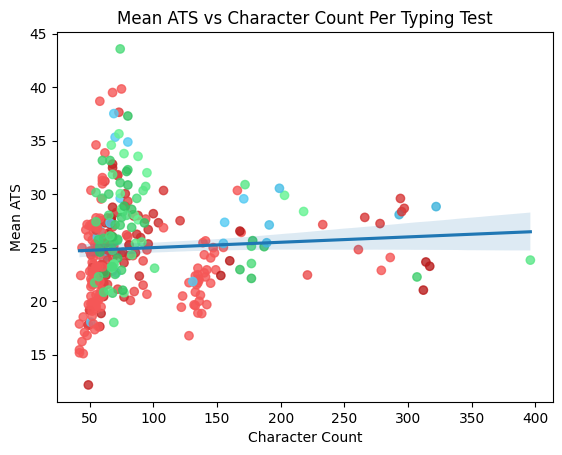

In [19]:
# Group data by testNum
groupTn = df.groupby('testNum')

# Plot a scatter plot with a regression line
reg = regplot(x='count', y='mean', data=groupTn.ats.describe(), scatter_kws={
	# Generate the colors for the graph
	'color': [langColors[df.language.iloc[ groupTn.indices[k][1] ]] + '80' for k in groupTn.indices]
})
reg.set_title('Mean ATS vs Character Count Per Typing Test')
reg.set_xlabel('Character Count')
reg.set_ylabel('Mean ATS')

# Show the correlation
print('Mean ATS vs Count Correlation:', groupTn.ats.describe().corr()['count'][1])

_Scatter plot of mean ATS vs character count in each test, Red for English tests, Green for Code tests, Blue for French tests_

There does not seem to be a strong correlation between typing score and character count, but the above graph does show that code tests generally had a higher typing score than other test language groups. This suggests that accuracy was lower or that speed was slower in these tests.

Text(0, 0.5, 'Mean ATS')

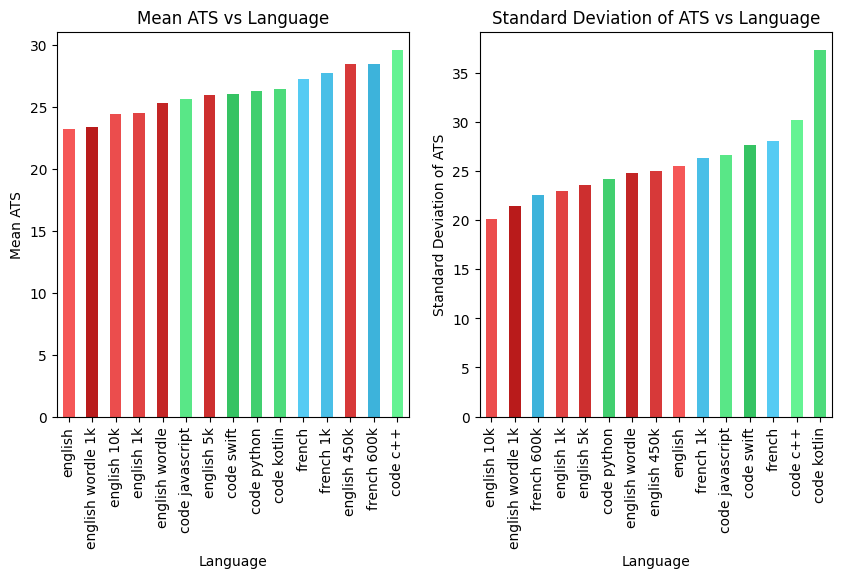

In [20]:
descGroupLang = df.groupby('language').ats.describe()

fig, (ax1, ax) = subplots(1, 2, figsize=(10, 5))
std = descGroupLang['std'].sort_values()
mean = descGroupLang['mean'].sort_values()
std.plot.bar(color=[langColors[x] for x in std.index], ax=ax)
mean.plot.bar(color=[langColors[x] for x in mean.index], ax=ax1)

ax.set_title('Standard Deviation of ATS vs Language')
ax.set_xlabel('Language')
ax.set_ylabel('Standard Deviation of ATS')

ax1.set_title('Mean ATS vs Language')
ax1.set_xlabel('Language')
ax1.set_ylabel('Mean ATS')

The preceding graph shows that coding language tests displayed a higher standard deviation when compared with other languages. C++, the language with the highest mean typing score and one of the highest amounts of variance, has a standard deviation that is more than 17% higher than the average standard deviation across all languages.

In [21]:
# C++'s standard deviation is more than 17% higher than the average
print(f"C++'s standard deviation for typing score: {round((std['code c++'] / std.mean() - 1) * 100, 3)}%")

C++'s standard deviation for typing score: 17.02%


### Speed, Accuracy, and Reach Length

Since typing score is dependent on speed and accuracy, we will explore them now.

The higher than average variance and mean typing score attributed to coding language tests is likely because of the symbols used in those kinds of tests exclusively. Among the words that took the most time to complete relative to their length are those with symbols. For example, the word "co_await", which is found in the __code c++__ language test, took 4.76 seconds to type. That is about 56% longer than the average time for a word of its length.

In [22]:
# Capture rows v - x to v + x
def surrounding(x, v):
	return [ x - v + i for i in range(v * 2 + 1)]

# Collect and sum the accuracy of the word co_await
co_await = df.iloc[surrounding(16648, 5)]
print(f'Typed {round(co_await.acc.mean(), 2)} times more letters than necessary in "co_await"') 

# Generate the average accuracy of a 8 letter word + a space
words = df[df.activeWord.str.len() == 9]
print(f'Typed {round(words.acc.mean(), 2)} times more letters than necessary on average')
print(f'Percent difference from mean: {round((co_await.acc.mean() - words.acc.mean()) * 100 / words.acc.mean(), 2)}%\n')
mean = round(words.cps.mean() * 9, 4)
co_await = co_await.cps.sum()


# Print findings
print('Time to type "co_await":', co_await, 'sec')
print('Time to type average 8 letter word:', mean, 'sec')
print(f'Percent difference from mean: {round((co_await - mean) * 100 / mean, 2)}%')

Typed 1.22 times more letters than necessary in "co_await"
Typed 1.14 times more letters than necessary on average
Percent difference from mean: 7.3%

Time to type "co_await": 4.757 sec
Time to type average 8 letter word: 3.0401 sec
Percent difference from mean: 56.48%


"co_await"'s high typing score is likely due to the speed because its accuracy was within one standard deviation of the accuracy distribution.

In [23]:
d = words.acc.describe()
print('-sigma < "co_await" accuracy mean < +sigma')
print(round(d['mean'] - d['std'], 2), '<', round(df.iloc[surrounding(16648, 5)].acc.mean(), 2), '<', round(d['mean'] + d['std'], 2))

-sigma < "co_await" accuracy mean < +sigma
0.95 < 1.22 < 1.33


"co_await" took a longer than the average 8 letter word with symbols, but the average word in its class still takes more than 40% longer to type than the mean.

In [24]:
# Collect the words with special characters
wordsWithSpecials = []
for x in df[df.activeWord.str.len() == 9].groupby('activeWord').indices.keys():
	for y in ['_', '-', '+', '=', '(', ')', '|', '<', '>', '.', ',']:
		if y in x:
			wordsWithSpecials += [x]
			break
wordsWithSpecials = df[df.activeWord.isin(wordsWithSpecials)]

# Generate the average time to type an 8 letter word with symbols + a space
symbols = round(wordsWithSpecials.cps.mean() * 9, 2)
print('Time to type average 8 letter word with symbols:', symbols, 'sec')
print(f'Percent difference from mean: {round((symbols - mean) * 100/ mean, 3)}%')


Time to type average 8 letter word with symbols: 4.28 sec
Percent difference from mean: 40.785%


This discrepancy is likely due to the greater than average __reachLength__ words with symbols have. 8 letter words with symbols have an average __reachLength__ of 3.2 units, versus normal words' 1.6 units.

In [25]:
# Compare mean reachLengths
print(f'Mean reach length with symbols: {wordsWithSpecials.reachLength.mean()} units')
print(f'Mean reach length: {words.reachLength.mean()} units')

Mean reach length with symbols: 3.190825688073394 units
Mean reach length: 1.5677419354838709 units


Some words in the code language sets are in camel case which require movements on and off the shift keys, in rapid succession. JavaScript has contains most of these words, which is likely why it has the highest mean cps.

## Classification

The ultimate object of this effort is to identify features that will yield the greatest gain in typing score when practiced. Although we have established that language features have a substantial effect on the typing score, a random forest classifier can help to find other useful features.

### Required Imports

In [26]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import plot_tree
from matplotlib.pyplot import show

### Feature Engineering Part 2

However, before we run the classifier, the null values in the __cps__ and __ats__ columns must be dropped because the classifier cannot understand null data. Consistency, language, and typing score are added because they are numerical columns (__language__ is numerical after one hot encoding) that are not dependent on each other. __Accuracy__ is included because it allows for the creation of the correct and incorrect categories.

In [27]:
cdf = df[['acc', 'ats',  'consistency', 'language']].dropna()
cdf.head()

,acc,ats,consistency,language
1,1.0,8.9,0.089,english wordle
2,1.0,12.3,0.034,english wordle
3,1.0,23.1,0.108,english wordle
4,1.0,6.2,-0.107,english wordle
5,1.0,12.2,0.120,english wordle


The classifier cannot understand categorical data either so the __languages__ will be One-Hot encoded.

In [28]:
oh = OneHotEncoder()
ohft = oh.fit_transform(cdf[['language']])
cdf[oh.categories_[0]] = ohft.toarray()
cdf = cdf.drop(columns=['language'])
cdf.head()

,acc,ats,consistency,code c++,code javascript,code kotlin,code python,code swift,english,english 10k,english 1k,english 450k,english 5k,english wordle,english wordle 1k,french,french 1k,french 600k
1,1.0,8.9,0.089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,12.3,0.034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,23.1,0.108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,6.2,-0.107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,1.0,12.2,0.120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Now we plug the data into the 5 Nearest Neighbors classifier.

In [29]:
x = cdf.iloc[:500, 1:-1]
cdf['accBool'] = cdf.acc.apply(lambda u: 1 if u == 1 else 0)
y = cdf.accBool.iloc[:500]
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=50)

forest = KNeighborsClassifier(n_neighbors=5)
forest.fit(X_train,y_train)
cross_val_score(forest, cdf.drop('accBool', axis=1), cdf.accBool, cv=10)

array([0.79848285, 0.78891821, 0.86836028, 0.75189706, 0.9056417 ,
       0.78027054, 0.72121412, 0.76938304, 0.7482679 , 0.69844936])

## Reflections

The performance analysis showed that perhaps I should remap some of the symbols to keys that are closer to the home row. I think it would have also been fruitful to record the backspaces and factor them into the analysis.